### Plotting the DEM + WD + Plotting the final flood depth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

base_dir = "/content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/"
print("Available folders:", os.listdir(base_dir))


Available folders: ['overview.csv', 'VX', 'WD', 'VY', 'DEM']


In [ ]:
# Global
# Importing all the libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# DEVICE (GPU if available)
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:" , device)


Using device: cuda


##.reshape():
- changes the shape of array/tensor without changing the elements inside of it
- The product of the new shape should be equal to the elements that the original tuple/array had

## torch.from_numpy():
- Creates torch tensors from a numpy array
- Convert the tensor created to the GPU using the .to(device) method

## .to(device):
- Move a tensor to a specific computing device (cpu or gpu)


In [ ]:
# ============================================================
# 1. LOAD DEM IN PYTORCH
# ============================================================

def load_dem_torch(base_path, sim_id):
  """
  Loads DEM_simID.txt and returns X, Y, Z as PyTorch tensors

  base_path: folder where DEM folder exists
  sim_id: simulation ID number
  """

  dem_file = os.path.join(base_path, "DEM", f"DEM_{sim_id}.txt")

  print(f"\nLoading DEM from: {dem_file}")

  #Shape -> (N, 3)
  #Columns -> X, Y, Z
  data = np.loadtxt(dem_file)

  x_raw = data[:, 0]
  y_raw = data[:, 1]
  z_raw = data[:, 2]

  xs = np.unique(x_raw)
  ys = np.unique(y_raw)

  ny = len(ys)
  nx = len(xs)

  #Reshape into 2D grids
  X = x_raw.reshape(ny, nx)
  Y = y_raw.reshape(ny, nx)
  Z = z_raw.reshape(ny, nx)

  #Convert to torch Tensors on GPU/CPU
  X = torch.from_numpy(X).float().to(device)
  Y = torch.from_numpy(Y).float().to(device)
  Z = torch.from_numpy(Z).float().to(device)

  print(f"DEM grid shape = {Z.shape} (ny = {ny}, nx = {nx}")
  print(f"Elevation: {Z.min().item():.2f} to {Z.max().item():.2f}")


  return X, Y, Z

## .detach()
- Returns a new tensor that shares the same underlying data as the orginal torch tensor but is detached from the computational graph

## .cpu()
- Moves the tensor's data from GPU to CPU

## .numpy()
- Converts the final tensor into Numpy array ready for use with other Python libraries

In [ ]:
# ============================================================
# 2. PLOT DEM (TENSOR)
# ============================================================
def plot_dem_torch(Z_torch, title="DEM Elevation"):
  """
  Plots a DEM stored as a PyTorch tensor
  """

  #Matplotlib only works with CPU

  Z = Z_torch.detach().cpu().numpy()  #convert to numpy for plotting

  plt.figure(figsize=(8,6))
  plt.imshow(Z, cmap="terrain", origin="lower")
  plt.colorbar(label="Elevation (m)")
  plt.title(title)
  plt.xlabel("X index")
  plt.ylabel("Y index")
  plt.tight_layout()
  plt.show()

In [ ]:
# ============================================================
# 3. LOAD WATER DEPTH (TENSOR)
# ============================================================
def load_wd_torch(base_path, sim_id, target_shape):
  """
  Loads WD simulation and reshapes into a PyTorch tensor:
  (time, ny, nx)

  Parameters:
  base_path: Path to the dataset folder
  sim_id: Simulation ID number
  target_shape: (ny, nx) taken from DEM
  """
  wd_file = os.path.join(base_path, "WD", f"WD_{sim_id}.txt")

  #Loading the data
  WD_np = np.loadtxt(wd_file)
  nt, n_flat = WD_np.shape

  #Extract target shape
  ny,nx = target_shape
  assert n_flat == ny * nx, f"WD grid mismatch: expected {ny*nx}, got {n_flat}"

  #Convert to PyTorch
  WD = (torch.from_numpy(WD_np).float().reshape(nt, ny, nx).to(device))

  print(f"WD tensor shape = {WD.shape} (time, ny, nx)")
  return WD

In [ ]:
# ============================================================
# 4. PLOT FINAL WATER DEPTH (TENSOR)
# ============================================================
def plot_final_wd_torch(WD_torch):
  """
  Plots the final water depth timestep
  """

  #Convert last timestep to CPU numpy
  final_depth = WD_torch[-1].detach().cpu().numpy()

  #Plot
  plt.figure(figsize=(8,6))
  plt.imshow(final_depth, cmap="Blues", origin="lower")
  plt.colorbar(label="Water depth (m)")
  plt.title("Final WD Depth (PyTorch)")
  plt.xlabel("X index")
  plt.ylabel("Y index")
  plt.tight_layout()
  plt.show()

In [ ]:
# ============================================================
# 5. CREATE A BREACH/INFLOW MASK IN DEM
# ============================================================
def create_breach_mask(grid_shape, row_start, row_end, col_start, col_end):
  """
  Create a breach/inflow mask as a PyTorch boolean tensor.
  True values mark the breach region

  grid_shape: (ny, nx)
  """
  ny, nx = grid_shape

  # Create a false mask on GPU
  mask = torch.zeros((ny, nx), dtype=torch.bool, device=device)

  #Apply the breach rectangle (inclusive)
  mask[row_start:row_end+1, col_start:col_end+1] = True

  return mask

## isinstance:
- Used to determine if an object is an instance of a specified class
- Type validation (object, classinfo)


In [ ]:
# ============================================================
# 6. PLOT DEM WITH THE BREACH
# ============================================================
def plot_breach_on_dem(Z, mask, title="Breach Location on DEM"):
  """
  Plot DEM with the breach/inflow mask overlay.
  Accepts both PyTorch and Numpy arrays
  """
  # Convert to CPU Numpy for plotting
  if isinstance(Z, torch.Tensor):
    Z = Z.detach().cpu().numpy()
  if isinstance(mask, torch.Tensor):
    mask = mask.detach().cpu().numpy()

  plt.figure(figsize=(10, 8))

  #Plot DEM
  plt.imshow(Z, cmap="terrain", origin="lower")
  plt.colorbar(label="Elevation (m)")

  #Overlay breach mask
  breach_y, breach_x = np.where(mask)
  plt.scatter(breach_x, breach_y, color="red", s=20, label="Breach Cells")

  plt.title(title, fontsize=14)
  plt.xlabel("X index")
  plt.ylabel("Y index")
  plt.legend()
  plt.tight_layout()
  plt.show()

### CA Function in PyTorch

##.clone()
- Creates a copy of the tensor

## Initially dry bed
- Start with no water anywhere
- Water level equals ground elevation

## Precompute neighbor topography
- Terrain is constant during the simulation
- duplicate the edges and do this calc once
- Z_up: takes the first row and all rows except last
- Z_dn: all rows except first and duplicate last row
- Z_lt: first column duplicated and all columns except last
- Z_rt: all columns except first and duplicate last column

## Torch.vstack()
- Vertically stacks a sequence of tensors

## Torch.clamp()
- Restricts all elements in an input tensor to a specified range(min, max)

## Torch.maximum()
- Element wise maximum of two tensors



In [ ]:
# ------------------------------------------------------------
# 7. CA into PyTorch
# ------------------------------------------------------------

def run_ca_swegnn_torch(
    Z,
    dx,
    t_end,
    inflow_mask,
    Q_in=50.0,
    n_manning=0.023,
    theta=0.7,
    CFL=1.0,
    dt_min=0.5,
    dt_max=15.0,
    depth_threshold=0.01,
):
    """
    PyTorch/GPU version of run_ca_swegnn.

    Parameters
    ----------
    Z : (ny, nx) array or torch.Tensor
        Ground elevation.
    dx : float
        Grid resolution (m).
    t_end : float
        Final time (s).
    inflow_mask : boolean array or torch.BoolTensor
        True where inflow occurs
    Q_in : float
        Constant inflow discharge [m³/s].
    n_manning : float
        Manning roughness coefficient.
    theta : float
        Relaxation parameter (0–1).
    CFL : float
        Courant number.
    dt_min, dt_max : float
        Min/max allowable time step (dt_min currently unused, like in your version).
    depth_threshold : float
        Wet-dry threshold.
    """

    # ------------------------------------------------------------
    # 1. Convert inputs to torch on GPU (float32)
    # ------------------------------------------------------------
    if isinstance(Z, torch.Tensor):
        Z_t = Z.to(device=device, dtype=torch.float32)
    else:
        Z_t = torch.from_numpy(np.asarray(Z, dtype=np.float32)).to(device)

    if isinstance(inflow_mask, torch.Tensor):
        inflow_mask_t = inflow_mask.to(device=device, dtype=torch.bool)
    else:
        inflow_mask_t = torch.from_numpy(
            np.asarray(inflow_mask, dtype=bool)
        ).to(device)

    ny, nx = Z_t.shape
    A = dx * dx  # cell area (scalar float)

    # Initially dry bed
    d = torch.zeros_like(Z_t, device=device)       # depth
    WL = Z_t.clone()                               # water level

    # ------------------------------------------------------------
    # 2. Precompute neighbour topography (fixed in time)
    # ------------------------------------------------------------
    Z_up = torch.vstack([Z_t[0:1, :], Z_t[:-1, :]])    # first row duplicated on top
    Z_dn = torch.vstack([Z_t[1:, :], Z_t[-1:, :]])     # last row duplicated at bottom
    Z_lt = torch.hstack([Z_t[:, 0:1], Z_t[:, :-1]])    # leftmost column duplicated
    Z_rt = torch.hstack([Z_t[:, 1:], Z_t[:, -1:]])     # rightmost column duplicated

    # ------------------------------------------------------------
    # 3. Output sampling setup
    # ------------------------------------------------------------
    t = 0.0
    step = 0

    dt_output = 1800.0  # save every 30 minutes
    sample_times = []
    depth_samples = []
    next_sample_time = 0.0

    # ------------------------------------------------------------
    # 4. Manning + Critical Velocity Cap (torch version)
    # ------------------------------------------------------------
    g = 9.81

    def vcap(d_if, slope):
        # slope, d_if >= small positive
        slope = torch.clamp(slope, min=1e-4)
        d_if = torch.clamp(d_if, min=1e-4)

        v_m = (1.0 / n_manning) * (d_if ** (2.0 / 3.0)) * torch.sqrt(slope)
        v_c = torch.sqrt(g * d_if)

        return torch.minimum(v_m, v_c)

    # ------------------------------------------------------------
    # 5. Compute time step – CFL based (torch version)
    # ------------------------------------------------------------
    def compute_dt(WL):
        WL_up = torch.vstack([WL[0:1, :], WL[:-1, :]])
        WL_dn = torch.vstack([WL[1:, :], WL[-1:, :]])
        WL_lt = torch.hstack([WL[:, 0:1], WL[:, :-1]])
        WL_rt = torch.hstack([WL[:, 1:], WL[:, -1:]])

        # interfacial depths
        d_if_up = torch.clamp(
            torch.maximum(WL, WL_up) - torch.maximum(Z_t, Z_up), min=0.0
        )
        d_if_dn = torch.clamp(
            torch.maximum(WL, WL_dn) - torch.maximum(Z_t, Z_dn), min=0.0
        )
        d_if_lt = torch.clamp(
            torch.maximum(WL, WL_lt) - torch.maximum(Z_t, Z_lt), min=0.0
        )
        d_if_rt = torch.clamp(
            torch.maximum(WL, WL_rt) - torch.maximum(Z_t, Z_rt), min=0.0
        )

        # surface slopes
        dWL_up = torch.clamp(WL - WL_up, min=0.0) / dx
        dWL_dn = torch.clamp(WL - WL_dn, min=0.0) / dx
        dWL_lt = torch.clamp(WL - WL_lt, min=0.0) / dx
        dWL_rt = torch.clamp(WL - WL_rt, min=0.0) / dx

        # velocities
        v_up = vcap(d_if_up, dWL_up)
        v_dn = vcap(d_if_dn, dWL_dn)
        v_lt = vcap(d_if_lt, dWL_lt)
        v_rt = vcap(d_if_rt, dWL_rt)

        vmax = torch.stack([
            v_up.max(),
            v_dn.max(),
            v_lt.max(),
            v_rt.max(),
            torch.tensor(1e-10, device=device)
        ]).max().item()

        dt = CFL * dx / vmax
        # keeping your "no clip" behaviour:
        # dt = float(np.clip(dt, dt_min, dt_max))
        return dt

    # ============================================================
    # MAIN LOOP
    # ============================================================
    while t < t_end:

        # wet fraction
        wet_cells = torch.count_nonzero(d > depth_threshold).item()
        wet_fraction = wet_cells / d.numel()

        # dt choice
        if wet_fraction < 0.002:
            dt = dt_max
        else:
            dt = compute_dt(WL)

        # prevent overshoot
        if t + dt > t_end:
            dt = t_end - t

        # --------------------------------------------------------
        # CONSTANT INFLOW
        # --------------------------------------------------------
        if Q_in > 0.0:
            vol_in = Q_in * dt
            dh_in = vol_in / A
            d[inflow_mask_t] += dh_in
            WL[inflow_mask_t] = Z_t[inflow_mask_t] + d[inflow_mask_t]

        # --------------------------------------------------------
        # NEIGHBOUR WATER LEVELS
        # --------------------------------------------------------
        WL_up = torch.vstack([WL[0:1, :], WL[:-1, :]])
        WL_dn = torch.vstack([WL[1:, :], WL[-1:, :]])
        WL_lt = torch.hstack([WL[:, 0:1], WL[:, :-1]])
        WL_rt = torch.hstack([WL[:, 1:], WL[:, -1:]])

        # interfacial depths
        d_if_up = torch.clamp(
            torch.maximum(WL, WL_up) - torch.maximum(Z_t, Z_up), min=0.0
        )
        d_if_dn = torch.clamp(
            torch.maximum(WL, WL_dn) - torch.maximum(Z_t, Z_dn), min=0.0
        )
        d_if_lt = torch.clamp(
            torch.maximum(WL, WL_lt) - torch.maximum(Z_t, Z_lt), min=0.0
        )
        d_if_rt = torch.clamp(
            torch.maximum(WL, WL_rt) - torch.maximum(Z_t, Z_rt), min=0.0
        )

        # water surface slopes
        dWL_up = torch.clamp(WL - WL_up, min=0.0) / dx
        dWL_dn = torch.clamp(WL - WL_dn, min=0.0) / dx
        dWL_lt = torch.clamp(WL - WL_lt, min=0.0) / dx
        dWL_rt = torch.clamp(WL - WL_rt, min=0.0) / dx

        # velocities
        v_up = vcap(d_if_up, dWL_up)
        v_dn = vcap(d_if_dn, dWL_dn)
        v_lt = vcap(d_if_lt, dWL_lt)
        v_rt = vcap(d_if_rt, dWL_rt)

        # fluxes
        F_up = v_up * d_if_up * dx * dt
        F_dn = v_dn * d_if_dn * dx * dt
        F_lt = v_lt * d_if_lt * dx * dt
        F_rt = v_rt * d_if_rt * dx * dt

        # volume in each cell
        V = d * A
        total_out = F_up + F_dn + F_lt + F_rt

        # prevent more outflow than water available (same logic as NumPy version)
        mask_over = total_out > V
        if mask_over.any():
            scale = V / torch.clamp(total_out, min=1e-12)
            F_up = F_up * scale
            F_dn = F_dn * scale
            F_lt = F_lt * scale
            F_rt = F_rt * scale

        # net volume change dV
        dV = torch.zeros_like(V, device=device)

        # up-down fluxes
        dV -= F_up
        dV[1:, :] += F_dn[:-1, :]
        dV -= F_dn
        dV[:-1, :] += F_up[1:, :]

        # left-right fluxes
        dV -= F_lt
        dV[:, 1:] += F_rt[:, :-1]
        dV -= F_rt
        dV[:, :-1] += F_lt[:, 1:]

        # update depth with relaxation
        d = torch.clamp(d + theta * (dV / A), min=0.0)
        WL = Z_t + d

        # time bookkeeping
        t += dt
        step += 1

        # store snapshots when crossing output time
        if t >= next_sample_time:
            sample_times.append(t)
            depth_samples.append(d.clone())  # keep on GPU
            next_sample_time += dt_output

    sample_times_out = np.array(sample_times, dtype=float)
    depth_samples_torch = torch.stack(depth_samples, dim=0)  # (nt_samples, ny, nx) on GPU

    return sample_times_out, depth_samples_torch


In [ ]:
# ============================================================
# 8. PLOT CA FINAL FLOOD DEPTH MAP
# ============================================================
def plot_final_depth(water_depth, sim_id):
  """
  Plot final flood depth map.

  Parameters:
  -----------
  water_depth: (time, ny, nx)
    - Water depth over time given by CA
  sim_id: simulation ID
  """

  #Check if tensor or numpy array
  if isinstance(water_depth, torch.Tensor):
    wd_cpu = water_depth.detach().cpu().numpy()

  else:
    wd_cpu = water_depth #already in numpy

  #wd_cpu shape is (nt, ny, nx)
  final_depth = wd_cpu[-1]  #Final Time Step

  plt.figure(figsize=(10, 8))

  #Plot the final water depth map
  im = plt.imshow(final_depth, cmap="Blues", origin="lower", vmin=0)
  plt.colorbar(im, label="Water Depth (m)")

  #Flood Statistics
  wet_cells = np.sum(final_depth > 0.01)    #count wet cells
  total_cells = final_depth.size            #total grid cells
  max_depth = final_depth.max()             #maximum flood depth

  #Is the max_depth one value or max in each grid over all timesteps?

  print(f"Simulation {sim_id} - Statistics")
  print(f"Wet cells: {wet_cells} / {total_cells}")
  print(f"Max depth: {max_depth:.3f} m")

  plt.title(f"Final Flood Depth Map (Sim {sim_id})")
  plt.xlabel(" X index")
  plt.ylabel(" Y index")
  plt.tight_layout()
  plt.show()

In [ ]:
# ============================================================
# 9. PLOT CA FINAL FLOOD DEPTH VS SWE-GNN FINAL FLOOD DEPTH
# ============================================================
def plot_CA_vs_WD(final_CA_depth, final_WD_depth, title="CA vs Delft-3D Flood Depth"):
  """
  Plot side-by-side comparison of final CA flood depth and Delft-3D flood depth (Ground Truth).
  """

  # Convert inputs to CPU Numpy arrays
  if isinstance(final_CA_depth, torch.Tensor):
    final_CA_depth = final_CA_depth.detach().cpu().numpy()

  if isinstance(final_WD_depth, torch.Tensor):
    final_WD_depth = final_WD_depth.detach().cpu().numpy()

  #Use a common max depth range for consistency
  vmax = max(final_CA_depth.max(), final_WD_depth.max())

  plt.figure(figsize=(14, 6))

  # CA Flood Depth
  plt.subplot(1, 2, 1)
  plt.imshow(final_CA_depth, origin="lower", cmap="Blues", vmin=0, vmax=vmax)
  plt.colorbar(label="Depth (m)")
  plt.title("Final CA Flood Depth")
  plt.xlabel("X index")
  plt.ylabel("Y index")

  #SWE-GNN Flood Depth
  plt.subplot(1,2,2)
  plt.imshow(final_WD_depth, origin="lower", cmap="Blues", vmin=0, vmax=vmax)
  plt.colorbar(label="Depth (m)")
  plt.title("Delft-3D Final Depth")
  plt.xlabel("X index")

  plt.suptitle(title, fontsize=14)
  plt.tight_layout()
  plt.show()

In [ ]:
# Load DEM (torch, GPU)
X1, Y1, Z1 = load_dem_torch(base_dir, sim_id=2)

# DEM shape
print("DEM shape:", Z1.shape)




Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_2.txt
DEM grid shape = torch.Size([64, 64]) (ny = 64, nx = 64
Elevation: -3.49 to 4.46
DEM shape: torch.Size([64, 64])


In [ ]:
mask1 = create_breach_mask(
    grid_shape=Z1.shape,
    row_start=0, row_end=3,
    col_start=0, col_end=7
)


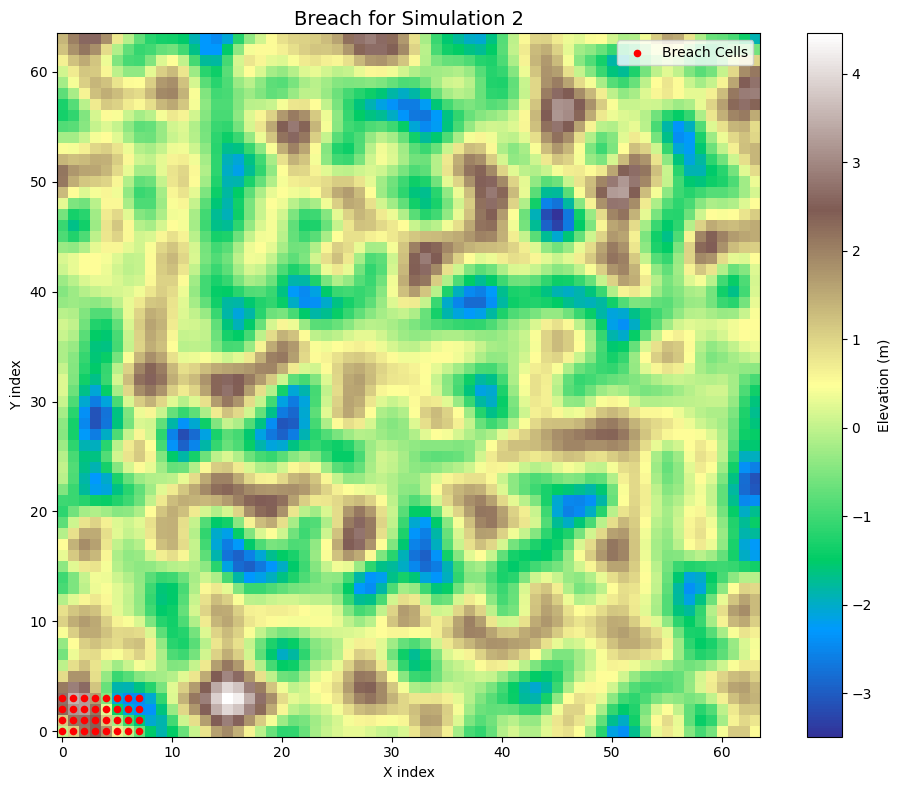

In [ ]:
plot_breach_on_dem(Z1, mask1, title="Breach for Simulation 2")


In [ ]:
dx = 100.0      # example grid size, modify if needed
t_end = 48 * 3600   # 48 hours

sample_times, depth_samples = run_ca_swegnn_torch(
    Z=Z1,
    dx=dx,
    t_end=t_end,
    inflow_mask=mask1,
    Q_in=50.0,
    n_manning=0.023,
    theta=0.7,
    CFL=1.0,
    dt_min=0.5,
    dt_max=30.0,
    depth_threshold=0.01
)

print("Times saved:", sample_times)
print("Depth samples tensor shape:", depth_samples.shape)  # (nt_samples, ny, nx)


Times saved: [3.00000000e+01 1.80667162e+03 3.60572509e+03 5.40883148e+03
 7.20567060e+03 9.00813720e+03 1.08045369e+04 1.26080191e+04
 1.44106521e+04 1.62089196e+04 1.80045384e+04 1.98051331e+04
 2.16028153e+04 2.34136849e+04 2.52030772e+04 2.70051197e+04
 2.88065201e+04 3.06002183e+04 3.24091469e+04 3.42080359e+04
 3.60030356e+04 3.78005654e+04 3.96057880e+04 4.14082300e+04
 4.32056838e+04 4.50024540e+04 4.68006340e+04 4.86121094e+04
 5.04001759e+04 5.22110316e+04 5.40104741e+04 5.58119366e+04
 5.76098149e+04 5.94114999e+04 6.12034028e+04 6.30032942e+04
 6.48043097e+04 6.66052819e+04 6.84004168e+04 7.02084038e+04
 7.20016086e+04 7.38047608e+04 7.56029720e+04 7.74089661e+04
 7.92117324e+04 8.10091766e+04 8.28122818e+04 8.46121748e+04
 8.64112416e+04 8.82122781e+04 9.00102124e+04 9.18027694e+04
 9.36083762e+04 9.54085783e+04 9.72113731e+04 9.90058686e+04
 1.00810562e+05 1.02600787e+05 1.04402385e+05 1.06209052e+05
 1.08012446e+05 1.09802251e+05 1.11610033e+05 1.13404077e+05
 1.15203005

In [ ]:
final_CA_depth = depth_samples[-1]   # (ny, nx) torch tensor on GPU


In [ ]:
WD1 = load_wd_torch(base_dir, sim_id=2, target_shape=Z1.shape)

final_WD_depth = WD1[-1]    # final timestep from SWE-GNN
print("Final WD depth shape:", final_WD_depth.shape)


WD tensor shape = torch.Size([97, 64, 64]) (time, ny, nx)
Final WD depth shape: torch.Size([64, 64])


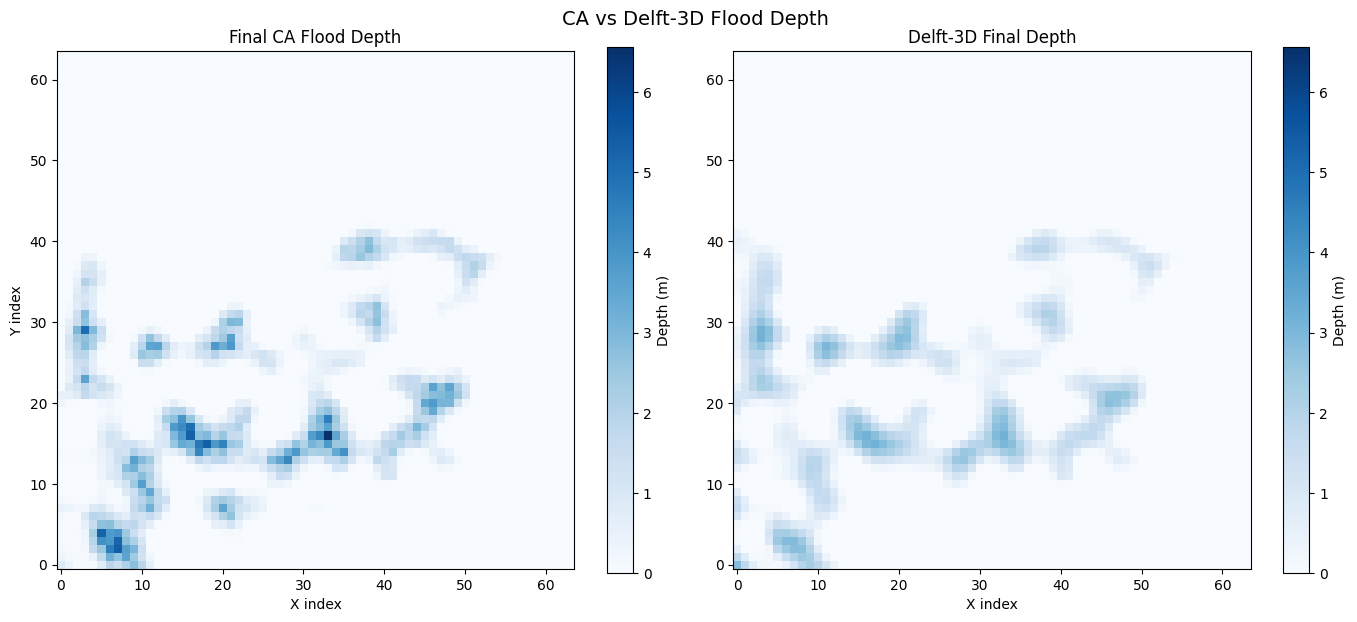

In [ ]:
plot_CA_vs_WD(final_CA_depth, final_WD_depth)


In [ ]:
print("Z1:", Z1.device)
print("mask1:", mask1.device)
print("final_CA_depth:", final_CA_depth.device)


Z1: cuda:0
mask1: cuda:0
final_CA_depth: cuda:0


# Running for a random simulation


Loading DEM from: /content/drive/MyDrive/Cellular Automata Model/SWE-GNN_Dataset/raw_datasets/raw_datasets/DEM/DEM_2.txt
DEM grid shape = torch.Size([64, 64]) (ny = 64, nx = 64
Elevation: -3.49 to 4.46
DEM shape: torch.Size([64, 64])


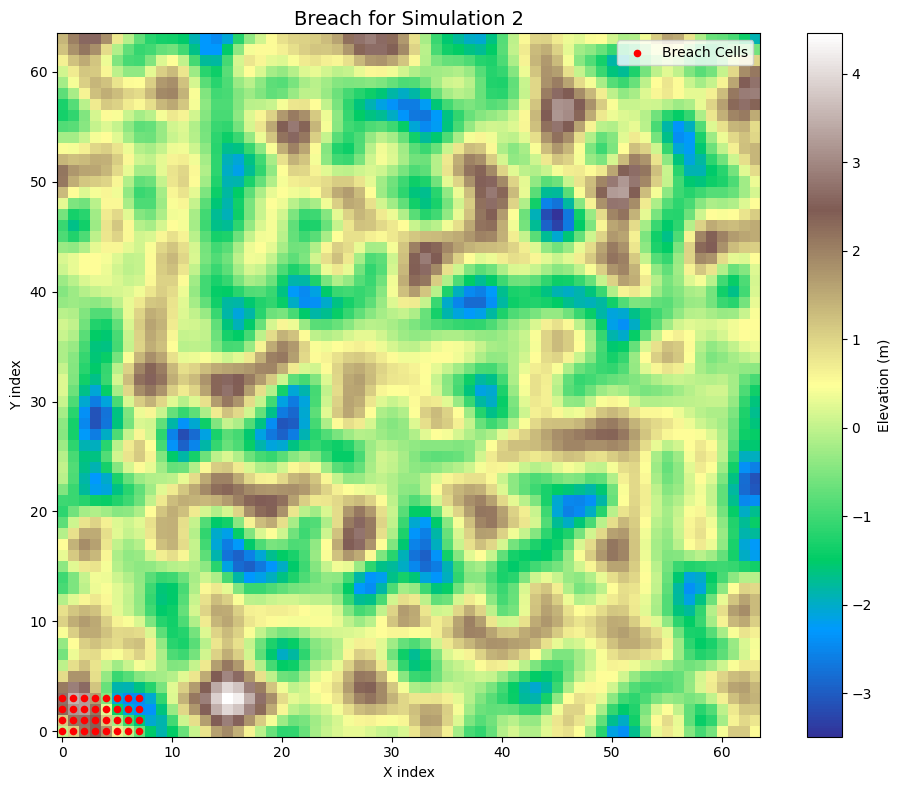

Times saved: [1.50000000e+01 1.80926084e+03 3.60745599e+03 5.40279047e+03
 7.20895278e+03 9.01235526e+03 1.08067242e+04 1.26032010e+04
 1.44031417e+04 1.62001354e+04 1.80004252e+04 1.98094859e+04
 2.16069315e+04 2.34110388e+04 2.52065424e+04 2.70007945e+04
 2.88126382e+04 3.06108571e+04 3.24064306e+04 3.42083754e+04
 3.60086563e+04 3.78094444e+04 3.96115677e+04 4.14052783e+04
 4.32019234e+04 4.50025477e+04 4.68117245e+04 4.86067466e+04
 5.04066369e+04 5.22061018e+04 5.40126427e+04 5.58027631e+04
 5.76006073e+04 5.94066731e+04 6.12063374e+04 6.30062131e+04
 6.48047974e+04 6.66026226e+04 6.84029637e+04 7.02044006e+04
 7.20117289e+04 7.38040581e+04 7.56012837e+04 7.74012686e+04
 7.92081143e+04 8.10097355e+04 8.28112402e+04 8.46063204e+04
 8.64068349e+04 8.82099476e+04 9.00043057e+04 9.18032919e+04
 9.36060677e+04 9.54056558e+04 9.72029614e+04 9.90068807e+04
 1.00804530e+05 1.02605155e+05 1.04408989e+05 1.06211805e+05
 1.08002401e+05 1.09811746e+05 1.11605026e+05 1.13406501e+05
 1.15202789

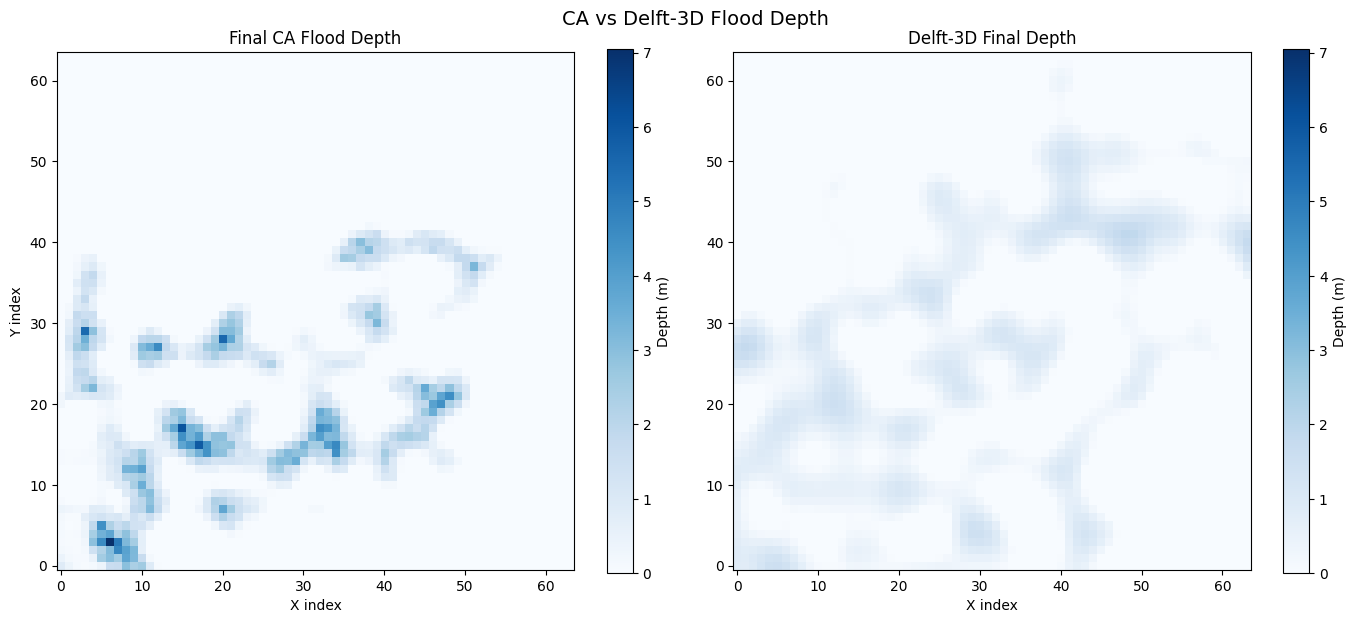

Z10: cuda:0
mask10: cuda:0
final_CA_depth: cuda:0


In [ ]:
# Load DEM (torch, GPU)
X2, Y2, Z2 = load_dem_torch(base_dir, sim_id=2)

# DEM shape
print("DEM shape:", Z2.shape)

mask10 = create_breach_mask(
    grid_shape=Z2.shape,
    row_start=0, row_end=3,
    col_start=0, col_end=7
)

plot_breach_on_dem(Z2, mask10, title="Breach for Simulation 2")

dx = 100.0      # example grid size, modify if needed
t_end = 48 * 3600   # 48 hours

sample_times, depth_samples = run_ca_swegnn_torch(
    Z=Z2,
    dx=dx,
    t_end=t_end,
    inflow_mask=mask10,
    Q_in=50.0,
    n_manning=0.03,
    theta=0.7,
    CFL=1.0,
    dt_min=0.5,
    dt_max=15.0,
    depth_threshold=0.01
)

print("Times saved:", sample_times)
print("Depth samples tensor shape:", depth_samples.shape)  # (nt_samples, ny, nx)

final_CA_depth = depth_samples[-1]   # (ny, nx) torch tensor on GPU

WD10 = load_wd_torch(base_dir, sim_id=10, target_shape=Z2.shape)

final_WD_depth = WD10[-1]    # final timestep from SWE-GNN
print("Final WD depth shape:", final_WD_depth.shape)

plot_CA_vs_WD(final_CA_depth, final_WD_depth)

print("Z10:", Z2.device)
print("mask10:", mask10.device)
print("final_CA_depth:", final_CA_depth.device)


Code to HTML

In [ ]:
import os, glob
# Replace 'MyProject.ipynb' with your actual file name
path = glob.glob('/content/drive/MyDrive/**/PyTorch_CA_Flood_model.ipynb', recursive=True)
print(path[0] if path else "File not found")

/content/drive/MyDrive/Colab Notebooks/PyTorch_CA_Flood_model.ipynb


In [ ]:
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/PyTorch_CA_Flood_model.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/PyTorch_CA_Flood_model.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 641256 bytes to /content/drive/MyDrive/Colab Notebooks/PyTorch_CA_Flood_model.html
